In [1]:
!pip install --upgrade d2l

In [34]:
import torch
from torch import nn
from d2l import torch as d2l # the book's API
from torch.nn import functional as F
import pandas as pd
import numpy as np

In [35]:
class HouseData(d2l.DataModule): # is subclass of d2l.DataModule
    def __init__(self, batch_size, train=None, val=None):
        super().__init__() # call parent class init()
        self.save_hyperparameters() # inherited from d2l.DataModule
        if self.train is None:
            self.raw_train = pd.read_csv("Kaggle_Housepricetrain.csv") #train.csv
            self.raw_val = pd.read_csv("Kaggle_Houseprice test.csv") #test.csv

    def preprocess(self):
        # Remove the ID and label columns
        label = 'SalePrice'
        features = pd.concat(
            (self.raw_train.drop(columns=['Id', label]),
             self.raw_val.drop(columns=['Id'])))
        # Standardize numerical columns
        numeric_features = features.dtypes[features.dtypes!='object'].index
        features[numeric_features] = features[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        # Replace NAN numerical features by 0
        features[numeric_features] = features[numeric_features].fillna(0)
        # Replace discrete features by one-hot encoding
        features = pd.get_dummies(features, dummy_na=True)
        # Save preprocessed features
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()

    def get_dataloader(self, train):
        label = 'SalePrice'
        data = self.train if train else self.val
        if label not in data: return
        get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
        # Logarithm of prices
        tensors = (get_tensor(data.drop(columns=[label])),  # X
                   torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
        return self.get_tensorloader(tensors, train)

In [36]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(HouseData(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

def k_fold(trainer, data, k, lr, mdl):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = mdl(lr, 331)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

In [37]:
class MyModel(d2l.Module):
    def __init__(self, lr, num_features):
        super().__init__()
        self.save_hyperparameters()
        self.net= nn.Linear(num_features, 1) # Vanilla Linear Regression 
        #self.net = nn.Sequential(nn.Linear(num_features, 79), nn.ReLU(), nn.Linear(79, 1))#, nn.ReLU(), nn.Linear(64, 1))
        #self.net = nn.Sequential(nn.Linear(2*num_features, 79), nn.ReLU(), nn.Linear(79, 1))#, nn.ReLU(), nn.Linear(64, 1))

    def forward(self, x):
        #x= torch.cat([x,x], dim= 1) # For doubling up the feature
        return self.net(x)

    def loss(self, y_hat, y):
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.lr)

In [38]:
data = HouseData(batch_size=32)
data.preprocess()

average validation log mse = 0.029745917208492755


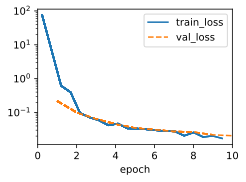

In [39]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, 5, 0.01, MyModel)

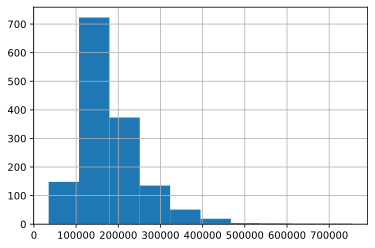

In [22]:
target= data.train['SalePrice']
import matplotlib.pyplot as plt

%matplotlib inline
target.hist()
plt.show()

<AxesSubplot:>

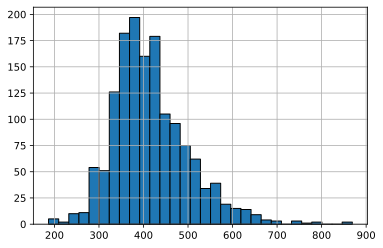

In [23]:
import numpy as np
np.sqrt(target).hist(bins= 30, edgecolor= 'black')

<AxesSubplot:>

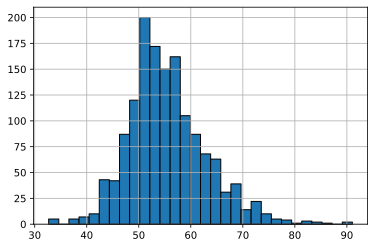

In [24]:
(target**(1/3)).hist(bins= 30, edgecolor= 'black')

In [40]:
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index= False)
#submission.to_csv('submission.csv', index=False)